In [1]:
# download txt from https://github.com/ceclinux/huffman/blob/master/莎士比亚全集英文版.txt and save it into data folder, use curl

import os
import numpy as np
import tqdm
!curl -o data/shakespeare.txt https://raw.githubusercontent.com/ceclinux/huffman/master/%E8%8E%8E%E5%A3%AB%E6%AF%94%E4%BA%9A%E5%85%A8%E9%9B%86%E8%8B%B1%E6%96%87%E7%89%88.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9937k  100 9937k    0     0  12.8M      0 --:--:-- --:--:-- --:--:-- 12.8M


In [2]:
# open the file and read the first 1000 characters
with open('data/shakespeare.txt', 'r') as file:
    text = file.read()
    print(text[:1000])

The Complete Works of William Shakespeare 
Welcome to the Web's first edition of 
the Complete Works of William 
Shakespeare. This site has offered 
Shakespeare's plays and poetry to the 
Internet community since 1993. 
Announcement: The restoration of the site 
following a disk failure has been delayed. The 
text of the plays is available now. The poetry 
and other services, including the search engine 
and forums, will return shortly. (Nov. 13, 2000) 
For other Shakespeare resources, visit the Mr. 
William Shakespeare and the Internet Web site. 
The original electronic source for this server is 
the Complete Moby(tm) Shakespeare, which is 
freely available online. The HTML versions of 
the plays provided here are placed in the public 
domain. 
Older news items 
Comedy History Tragedy Poetry 

All's Well That Ends Well 
As You Like It 
The Comedy of Errors 
Cymbeline 
Love's Labours Lost 
Measure for Measure 
The Merry Wives of Windsor 
The Merchant of Venice 
A Midsummer Night's Dre

In [3]:
import re
tokens = re.findall(r"[a-zA-Z]+|[^\s\w]|[\n]", text)
print(tokens[:100])

['The', 'Complete', 'Works', 'of', 'William', 'Shakespeare', '\n', 'Welcome', 'to', 'the', 'Web', "'", 's', 'first', 'edition', 'of', '\n', 'the', 'Complete', 'Works', 'of', 'William', '\n', 'Shakespeare', '.', 'This', 'site', 'has', 'offered', '\n', 'Shakespeare', "'", 's', 'plays', 'and', 'poetry', 'to', 'the', '\n', 'Internet', 'community', 'since', '.', '\n', 'Announcement', ':', 'The', 'restoration', 'of', 'the', 'site', '\n', 'following', 'a', 'disk', 'failure', 'has', 'been', 'delayed', '.', 'The', '\n', 'text', 'of', 'the', 'plays', 'is', 'available', 'now', '.', 'The', 'poetry', '\n', 'and', 'other', 'services', ',', 'including', 'the', 'search', 'engine', '\n', 'and', 'forums', ',', 'will', 'return', 'shortly', '.', '(', 'Nov', '.', ',', ')', '\n', 'For', 'other', 'Shakespeare', 'resources', ',']


In [4]:
# create a frequency table, from highest to lowest, and draw a bar chart
from collections import Counter
import matplotlib.pyplot as plt
frequency = Counter(tokens)
frequency = dict(sorted(frequency.items(), key=lambda x: x[1], reverse=True))

Text(0, 0.5, 'Frequency')

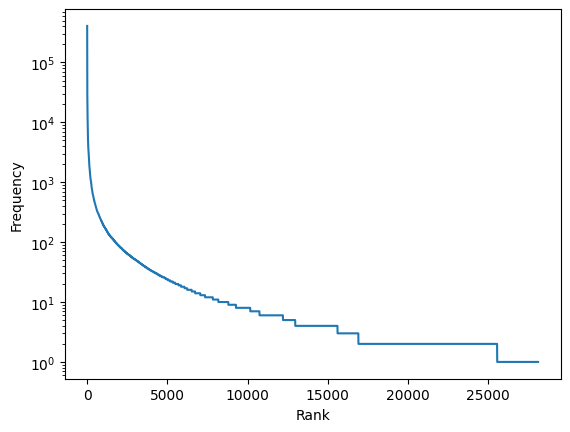

In [5]:
plt.plot(frequency.values())
plt.semilogy()
plt.xlabel('Rank')
plt.ylabel('Frequency')

In [6]:
vocab_size = 1000
frequency = dict(list(frequency.items())[:vocab_size])
transition_matrix = np.zeros((vocab_size, vocab_size), dtype=int)

for i in tqdm.tqdm(range(1, len(tokens))):
    left = tokens[i-1]
    right = tokens[i]
    if left in frequency and right in frequency:
        transition_matrix[list(frequency.keys()).index(left)][list(frequency.keys()).index(right)] += 1

100%|██████████| 2425498/2425498 [00:16<00:00, 149431.91it/s]


In [11]:
# generate according to the transition matrix
def generate(first='the', length=100):
    sentence = [first]
    index = list(frequency.keys()).index(first)
    for _ in range(length):
        next_index = np.random.choice(vocab_size, p=transition_matrix[index]/transition_matrix[index].sum())
        sentence.append(list(frequency.keys())[next_index])
        index = next_index
    return ' '.join(sentence)

print(generate('she'))

she ' s head for you thank thee and to the English crown upon a devil , or your favour . The law . 
 
 JULIA 
 
 Nor I pray you are not speak of York , my fair sister shall not have they ' t please your father , I will not hear 
 What is yours , in a word of it 
 
 To stand 
 Here , that end 
 
 
 The mean a gentleman . 
 If Warwick , and by your grace , I think my lord . 
 
 
 cannot


# RNN

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

In [13]:
class RNNScratch(nn.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, input_dim, hidden_dim, sigma=0.01):
        super().__init__()

        self.input_dim, self.hidden_dim = input_dim, hidden_dim
        self.W_ih = nn.Parameter(
            torch.randn(input_dim, hidden_dim) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(hidden_dim, hidden_dim) * sigma)
        self.b_h = nn.Parameter(torch.zeros(hidden_dim)) # equivalenet to b_ih + b_hh in the slides notation.


    def forward(self, inputs, state=None):
        # inputs shape: (num_steps, batch_size, input_dim)
        # state shape: (batch_size, hidden_dim)
        if state is None:
            # Initial state with shape: (batch_size, hidden_dim)
            state = torch.zeros((inputs.shape[1], self.hidden_dim),
                            device=inputs.device)
        else:
            state, = state
        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, input_dim)
            state = torch.tanh(torch.matmul(X, self.W_ih) +
                            torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return torch.stack(outputs), (state,)
    
rnn = RNNScratch(input_dim=16, hidden_dim=512)
    

# create a input sequence
LEN = 100 # sequence length
BATCH = 32 # batch size
DIM = 16 # input dimension
x = torch.randn(LEN, BATCH, DIM)
y, state = rnn(x)

In [14]:
print("output shape:", y.shape) # sequence length * batch size * hidden dimension
print("state shape:", state[0].shape) # batch size * hidden dimension

output shape: torch.Size([100, 32, 512])
state shape: torch.Size([32, 512])
